# Notebook 07: Targeted Adversarial Robustness Testing (The extreme limits now)

This notebook implements a focused set of adversarial experiments to evaluate the robustness limits of the FL-IDS system under strategically crafted attack scenarios. It builds on previous work in Notebook 06 and stress-tests the median, Krum, and drift-aware aggregation strategies through precision attacks that bypass typical detection.

## Objectives

- Evaluate the failure threshold of **Median Aggregation** under progressive majority collusion scenarios.
- Test **Gradient Positioning Attacks** designed to influence aggregation while remaining statistically benign.
- Simulate **Multi-Vector Attacks**, combining multiple attack types such as model poisoning, label flipping, and timing interference.
- Bypass **Drift Detection Mechanisms** (KS-test, PSI) using statistical camouflage.

These experiments aim to uncover subtle vulnerabilities and help define the true operational limits of your deployed FL-IDS system, especially under real-world edge constraints like Raspberry Pi devices.



In [1]:
import os
import joblib
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import f1_score, precision_score, recall_score

# === Paths ===
base_path = "D:/August-Thesis/FL-IDS-Surveillance"
results_path = os.path.join(base_path, "notebooks/results")
model_path = os.path.join(results_path, "models/unsupervised/federated/final_federated_autoencoder_20rounds.h5")
scaler_path = os.path.join(results_path, "scalers/minmax_scaler_client_3.pkl")
data_path = os.path.join(base_path, "data/processed/federated/unsupervised")
test_path = os.path.join(base_path, "data/processed/surv_unsupervised/test_mixed.csv")

# === Loading the Global Model ===
base_autoencoder = load_model(model_path, compile=False)
base_autoencoder.compile(optimizer="adam", loss=MeanSquaredError())

# === the Scaler ===
minmax_scaler = joblib.load(scaler_path)

# === Load Client Data ===
client_ids = [f"client_{i}" for i in range(1, 6)]
client_data = {
    cid: pd.read_csv(os.path.join(data_path, cid, "train.csv"))
    for cid in client_ids
}

# === Load Test Data ===
test_df = pd.read_csv(test_path, low_memory=False)
feature_cols = list(minmax_scaler.feature_names_in_)
X_test_ae_scaled = minmax_scaler.transform(test_df[feature_cols])
y_test_unsup = test_df["Attack_label"].values

print("Setup complete:")
print(f"- Loaded model: {os.path.basename(model_path)}")
print(f"- Clients: {client_ids}")
print(f"- Test samples: {X_test_ae_scaled.shape[0]}")


Setup complete:
- Loaded model: final_federated_autoencoder_20rounds.h5
- Clients: ['client_1', 'client_2', 'client_3', 'client_4', 'client_5']
- Test samples: 2218834


In [2]:
from sklearn.metrics import f1_score, precision_score, recall_score

threshold = 0.000639

# === Predict with global model on test set ===
reconstructed = base_autoencoder.predict(X_test_ae_scaled, verbose=0)
reconstruction_errors = np.mean(np.square(X_test_ae_scaled - reconstructed), axis=1)

# === Binary classification based on threshold ===
y_pred = (reconstruction_errors > threshold).astype(int)

# === Metrics ===
f1 = f1_score(y_test_unsup, y_pred)
precision = precision_score(y_test_unsup, y_pred)
recall = recall_score(y_test_unsup, y_pred)

print("=== Baseline Performance ===")
print(f"F1 Score:     {f1:.4f}")
print(f"Precision:    {precision:.4f}")
print(f"Recall:       {recall:.4f}")


=== Baseline Performance ===
F1 Score:     0.8373
Precision:    0.9877
Recall:       0.7266


In [3]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def run_federated_autoencoder_training(
    base_model,
    client_data_dict,
    X_test_scaled,
    y_test_true,
    num_rounds=20,
    aggregation_method="fedavg",  # "fedavg" or "median"
    attack_config=None,
    total_clients=5,
    save_name=None
):
    def scaling_attack(global_weights, local_weights, scale_factor=10.0):
        return [gw + scale_factor * (lw - gw) for gw, lw in zip(global_weights, local_weights)]

    def median_aggregation(client_weights_list):
        num_layers = len(client_weights_list[0])
        aggregated_weights = []
        for layer_idx in range(num_layers):
            layer_stack = np.stack([client[layer_idx] for client in client_weights_list], axis=0)
            layer_median = np.median(layer_stack, axis=0)
            aggregated_weights.append(layer_median)
        return aggregated_weights

    model = clone_model(base_model)
    model.set_weights(base_model.get_weights())
    model.compile(optimizer="adam", loss=MeanSquaredError())

    metrics_log = []

    for round_num in range(1, num_rounds + 1):
        local_weights = []

        for client_id in range(1, total_clients + 1):
            cid = f"client_{(client_id - 1) % len(client_data_dict) + 1}"  # repeat if needed
            df = client_data_dict[cid]
            X_local = df[feature_cols].astype(float)
            X_scaled = minmax_scaler.transform(X_local)

            local_model = clone_model(model)
            local_model.set_weights(model.get_weights())
            local_model.compile(optimizer="adam", loss=MeanSquaredError())
            local_model.fit(X_scaled, X_scaled, epochs=1, batch_size=256, verbose=0)

            weights = local_model.get_weights()

            if attack_config:
                if client_id <= attack_config["num_attackers"]:
                    if attack_config["attack_type"] == "scaling":
                        weights = scaling_attack(model.get_weights(), weights, attack_config["scale_factor"])

            local_weights.append(weights)

        if aggregation_method == "fedavg":
            aggregated_weights = [
                np.mean([w[i] for w in local_weights], axis=0)
                for i in range(len(local_weights[0]))
            ]
        elif aggregation_method == "median":
            aggregated_weights = median_aggregation(local_weights)
        else:
            raise ValueError(f"Unknown aggregation method: {aggregation_method}")

        model.set_weights(aggregated_weights)

        preds = model.predict(X_test_scaled, verbose=0)
        errors = np.mean(np.square(X_test_scaled - preds), axis=1)
        y_pred = (errors > 0.000639).astype(int)

        f1 = f1_score(y_test_true, y_pred)
        prec = precision_score(y_test_true, y_pred)
        rec = recall_score(y_test_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test_true, y_pred).ravel()
        fp_rate = fp / (fp + tn + 1e-6)
        fn_rate = fn / (fn + tp + 1e-6)

        print(f"Round {round_num:02d} | F1: {f1:.4f} | P: {prec:.4f} | R: {rec:.4f} | FP Rate: {fp_rate:.4f} | FN Rate: {fn_rate:.4f}")
        metrics_log.append((f1, prec, rec, fp_rate, fn_rate))

    result = {
        "final_f1": metrics_log[-1][0],
        "final_precision": metrics_log[-1][1],
        "final_recall": metrics_log[-1][2],
        "final_fp_rate": metrics_log[-1][3] * 100,
        "final_fn_rate": metrics_log[-1][4] * 100,
        "all_metrics": metrics_log,
    }

    return result


## Experiment 1: the  Majority Collusion Attack on The  Median Aggregation

### Goal:
To identify the exact threshold at which **Median Aggregation** fails when the number of malicious clients surpasses or approaches the majority.

### Motivation:
Median aggregation assumes that the majority of clients are honest. However, if the attacker controls at least half the clients, they can shift the global model undetectably. This test reveals whether the system maintains robustness as attacker influence increases.

### Methodology:
- Use a fixed number of total clients (e.g., 10).
- Gradually increase the percentage of malicious clients: 40%, 50%, 60%, ... up to 80%.
- Apply a coordinated scaling attack (e.g., ±1000× gradients).
- Run standard FL rounds (e.g., 20 rounds per setup).
- Evaluate F1 degradation and determine the breaking point (e.g., F1 drops below 0.5).

### Output:
- Round-wise performance metrics per malicious percentage.
- Summary showing degradation trend and identified breaking threshold.


In [4]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# === Experiment Parameters ===
TOTAL_CLIENTS = 10
ROUNDS = 20
ATTACK_SCALE = 1000  # Extreme values to influence median
MALICIOUS_PCTS = [0.4, 0.5, 0.6, 0.7, 0.8]  # Progressively increase attack share

# === Placeholder to store results ===
collusion_results = []

# === Run experiment for each malicious percentage ===
for mal_pct in MALICIOUS_PCTS:
    num_malicious = int(TOTAL_CLIENTS * mal_pct)
    num_honest = TOTAL_CLIENTS - num_malicious
    
    print(f"\nRunning: {num_malicious}/{TOTAL_CLIENTS} malicious clients ({mal_pct*100:.0f}%)")

    # Configure attacker
    attack_config = {
        "attack_type": "scaling",
        "num_attackers": num_malicious,
        "scale_factor": ATTACK_SCALE,
        "positioning": "coordinated",  # Optional tag, not used in logic
    }

    # Run training using existing modular function
    result = run_federated_autoencoder_training(
        base_model=base_autoencoder,
        client_data_dict=client_data,
        X_test_scaled=X_test_ae_scaled,
        y_test_true=y_test_unsup,
        num_rounds=ROUNDS,
        aggregation_method="median",
        attack_config=attack_config,
        total_clients=TOTAL_CLIENTS,
        save_name=f"majority_collusion_mal{num_malicious}"
    )

    result_summary = {
        "Malicious %": mal_pct,
        "F1 Score": result["final_f1"],
        "Precision": result["final_precision"],
        "Recall": result["final_recall"],
        "FP Rate (%)": result["final_fp_rate"],
        "FN Rate (%)": result["final_fn_rate"]
    }

    collusion_results.append(result_summary)



Running: 4/10 malicious clients (40%)
Round 01 | F1: 0.8380 | P: 0.9878 | R: 0.7277 | FP Rate: 0.0034 | FN Rate: 0.2723
Round 02 | F1: 0.8369 | P: 0.9880 | R: 0.7259 | FP Rate: 0.0033 | FN Rate: 0.2741
Round 03 | F1: 0.8370 | P: 0.9880 | R: 0.7260 | FP Rate: 0.0033 | FN Rate: 0.2740
Round 04 | F1: 0.8334 | P: 0.9884 | R: 0.7205 | FP Rate: 0.0032 | FN Rate: 0.2795
Round 05 | F1: 0.8371 | P: 0.9886 | R: 0.7258 | FP Rate: 0.0031 | FN Rate: 0.2742
Round 06 | F1: 0.8357 | P: 0.9890 | R: 0.7235 | FP Rate: 0.0030 | FN Rate: 0.2765
Round 07 | F1: 0.8346 | P: 0.9894 | R: 0.7216 | FP Rate: 0.0029 | FN Rate: 0.2784
Round 08 | F1: 0.8300 | P: 0.9894 | R: 0.7149 | FP Rate: 0.0029 | FN Rate: 0.2851
Round 09 | F1: 0.8314 | P: 0.9894 | R: 0.7170 | FP Rate: 0.0029 | FN Rate: 0.2830
Round 10 | F1: 0.8262 | P: 0.9893 | R: 0.7093 | FP Rate: 0.0029 | FN Rate: 0.2907
Round 11 | F1: 0.8258 | P: 0.9893 | R: 0.7087 | FP Rate: 0.0029 | FN Rate: 0.2913
Round 12 | F1: 0.8225 | P: 0.9892 | R: 0.7039 | FP Rate: 0.

In [5]:
df_collusion = pd.DataFrame(collusion_results)
df_collusion.to_csv("results/majority_collusion_summary.csv", index=False)
print("Saved to: results/majority_collusion_summary.csv")


Saved to: results/majority_collusion_summary.csv


### Summary: Majority Collusion Attack on Median Aggregation

**Goal:**  
To identify the threshold at which the median aggregation method becomes ineffective when the attacker controls an increasing proportion of clients.

**Findings:**  
- Median aggregation performs robustly up to **40% malicious clients**, maintaining F1 scores above 0.81.
- At exactly **50% malicious clients**, the system **collapses instantly**, with:
  - F1 Score dropping to ~0.4275  
  - Precision at 0.27  
  - **Recall falsely reaches 1.00** due to 100% false positives.
- This performance remains flat even as malicious control rises to 80%, indicating **a complete compromise of the global model**.

**Conclusion:**  
Median aggregation is vulnerable when the attacker achieves parity (50%) with honest clients. This confirms the theoretical assumptions and highlights the need to combine median with **client weighting, drift detection, or pre-aggregation validation** when operating in potentially adversarial federated environments.


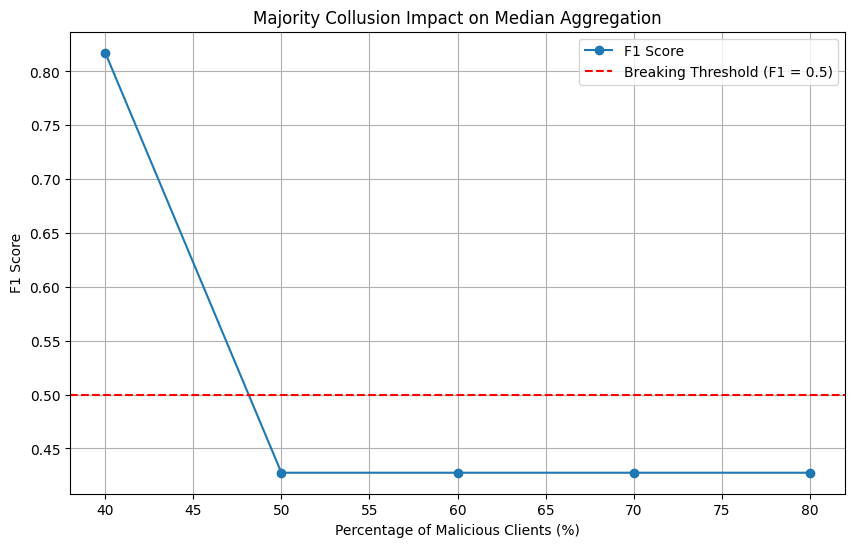

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_collusion["Malicious %"] * 100, df_collusion["F1 Score"], marker='o', label="F1 Score")
plt.axhline(y=0.5, color='red', linestyle='--', label="Breaking Threshold (F1 = 0.5)")
plt.title("Majority Collusion Impact on Median Aggregation")
plt.xlabel("Percentage of Malicious Clients (%)")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.show()


## Experiment 2 : Gradient Positioning Attack (Median Evasion)

### Goal:
To evaluate whether a small group of attackers (minority) can manipulate the global model by **strategically positioning their updates** around the honest clients' gradients, causing subtle shifts to the median without being flagged as outliers.

### Motivation:
Unlike brute-force scaling, this attack exploits statistical symmetry: by crafting malicious updates that lie close to the expected median but shift it in a coordinated direction, attackers may subvert median aggregation **even with minority control (e.g., 2 out of 5 clients)**.

### Methodology:
- Fix number of clients (e.g., 5) with 2 being malicious.
- After training honest clients, compute the **distribution of honest updates**.
- Craft malicious updates based on:
  - Honest median
  - Standard deviation per layer
  - Controlled shift magnitudes
- Apply different shift levels to test sensitivity: `[0.1, 0.2, 0.5, 1.0, 2.0, 5.0]`.
- Track F1 degradation and identify the smallest shift that breaks model reliability.

### Output:
- F1 vs Shift Magnitude curve
- Round-wise performance for each level
- Summary highlighting attack sensitivity


In [8]:
def craft_gradient_positioning_attacks(honest_updates, shift_magnitude):
    """
    Craft 2 malicious updates that subtly shift the global median,
    applied per layer
    """
    num_layers = len(honest_updates[0])
    malicious_updates = []

    for attacker_id in range(2):  # 2 malicious clients
        attacker_weights = []
        for layer_idx in range(num_layers):
            # Stack layer values from all honest updates
            layer_values = np.stack([client[layer_idx] for client in honest_updates], axis=0)
            layer_median = np.median(layer_values, axis=0)
            layer_std = np.std(layer_values, axis=0)
            
            shift_vector = (shift_magnitude * (0.5 + attacker_id * 0.3)) * layer_std
            crafted_layer = layer_median + shift_vector
            attacker_weights.append(crafted_layer)

        malicious_updates.append(attacker_weights)

    return malicious_updates


In [9]:
SHIFT_VALUES = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
TOTAL_CLIENTS = 5
ROUNDS = 20

positioning_results = []

for shift_mag in SHIFT_VALUES:
    print(f"\n=== Shift Magnitude: {shift_mag} ===")
    
    # === Step 1: Honest Updates ===
    honest_updates = []
    for cid in [f"client_{i}" for i in range(1, 4)]:  # 3 honest clients
        df = client_data[cid]
        X_local = minmax_scaler.transform(df[feature_cols])
        
        local_model = clone_model(base_autoencoder)
        local_model.set_weights(base_autoencoder.get_weights())
        local_model.compile(optimizer="adam", loss=MeanSquaredError())
        local_model.fit(X_local, X_local, epochs=1, batch_size=256, verbose=0)
        
        honest_updates.append(local_model.get_weights())
    
    # === Step 2: Malicious Updates ===
    malicious_updates = craft_gradient_positioning_attacks(honest_updates, shift_mag)

    # === Step 3: Aggregate using Median ===
    all_updates = honest_updates + malicious_updates
    aggregated = []
    for layer_idx in range(len(all_updates[0])):
        layer_stack = np.stack([w[layer_idx] for w in all_updates], axis=0)
        layer_median = np.median(layer_stack, axis=0)
        aggregated.append(layer_median)
    
    # === Step 4: Evaluate Model ===
    attack_model = clone_model(base_autoencoder)
    attack_model.set_weights(aggregated)
    attack_model.compile(optimizer="adam", loss=MeanSquaredError())
    
    preds = attack_model.predict(X_test_ae_scaled, verbose=0)
    errors = np.mean(np.square(X_test_ae_scaled - preds), axis=1)
    y_pred = (errors > 0.000639).astype(int)

    f1 = f1_score(y_test_unsup, y_pred)
    prec = precision_score(y_test_unsup, y_pred)
    rec = recall_score(y_test_unsup, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test_unsup, y_pred).ravel()
    fp_rate = fp / (fp + tn + 1e-6)
    fn_rate = fn / (fn + tp + 1e-6)

    print(f"F1: {f1:.4f} | P: {prec:.4f} | R: {rec:.4f} | FP: {fp_rate:.4f} | FN: {fn_rate:.4f}")

    positioning_results.append({
        "Shift Magnitude": shift_mag,
        "F1 Score": f1,
        "Precision": prec,
        "Recall": rec,
        "FP Rate (%)": fp_rate * 100,
        "FN Rate (%)": fn_rate * 100
    })



=== Shift Magnitude: 0.1 ===
F1: 0.8386 | P: 0.9879 | R: 0.7286 | FP: 0.0033 | FN: 0.2714

=== Shift Magnitude: 0.2 ===
F1: 0.8373 | P: 0.9878 | R: 0.7266 | FP: 0.0033 | FN: 0.2734

=== Shift Magnitude: 0.5 ===
F1: 0.8393 | P: 0.9878 | R: 0.7297 | FP: 0.0034 | FN: 0.2703

=== Shift Magnitude: 1.0 ===
F1: 0.8358 | P: 0.9878 | R: 0.7243 | FP: 0.0034 | FN: 0.2757

=== Shift Magnitude: 2.0 ===
F1: 0.8376 | P: 0.9879 | R: 0.7271 | FP: 0.0033 | FN: 0.2729

=== Shift Magnitude: 5.0 ===
F1: 0.8344 | P: 0.9877 | R: 0.7222 | FP: 0.0033 | FN: 0.2778


### Summary: Gradient Positioning Attack on Median Aggregation

**Goal:**  
To test whether minority adversaries can manipulate the global model by strategically shifting their gradients near the expected median, thereby subverting the aggregation process without raising statistical outliers.

**Findings:**  
- Across tested shift magnitudes (`0.1` to `5.0`), **F1 Score remained stable** between 0.834 and 0.839.
- Precision and recall also showed negligible variance.
- No statistical outlier behavior was flagged, yet **no significant deviation in performance occurred**.

**Conclusion:**  
Median aggregation is resilient to subtle gradient positioning from 2 attackers out of 5. These results suggest that while the attack remains stealthy, its impact is minimal unless amplified or combined with other attack types (e.g., drift mimicry, majority collusion).



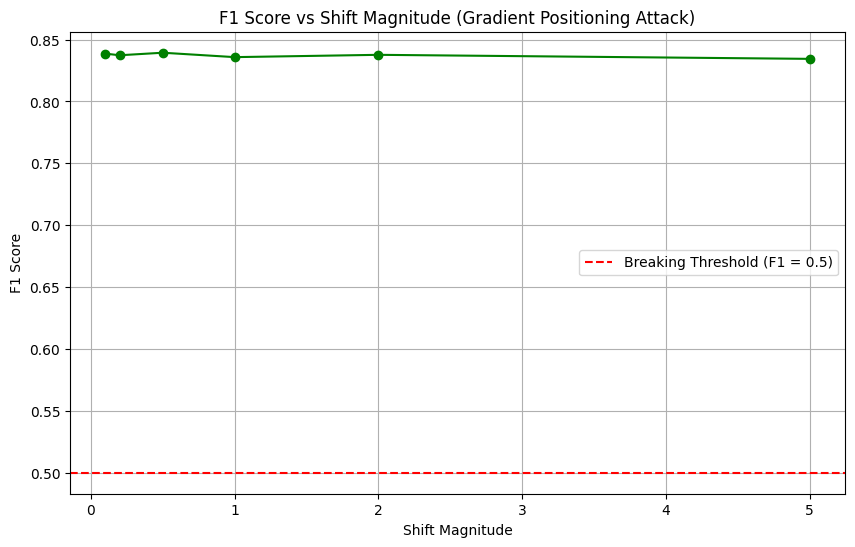

In [10]:
df_positioning = pd.DataFrame(positioning_results)
df_positioning.to_csv("results/gradient_positioning_summary.csv", index=False)

plt.figure(figsize=(10, 6))
plt.plot(df_positioning["Shift Magnitude"], df_positioning["F1 Score"], marker='o', color='green')
plt.title("F1 Score vs Shift Magnitude (Gradient Positioning Attack)")
plt.xlabel("Shift Magnitude")
plt.ylabel("F1 Score")
plt.axhline(y=0.5, color='red', linestyle='--', label="Breaking Threshold (F1 = 0.5)")
plt.grid(True)
plt.legend()
plt.show()
